Install libraries:

In [1]:
!pip install las
from las import LASReader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/millennial-geoscience/Common_Ss_geodata_examples/main/pnbsct_hz_by_il_xl.dat
!wget https://raw.githubusercontent.com/seg/tutorials-2014/master/1406_Make_a_synthetic/L-30.las

/bin/bash: wget: command not found
/bin/bash: wget: command not found


Load horizon data:

In [2]:
pnts = np.loadtxt('pnbsct_hz_by_il_xl.dat')
hx,hy,twt = pnts[:,1],pnts[:,0],pnts[:,2]
print(pnts[0:5])

[[200.         700.         529.68555689]
 [200.         702.         529.52373028]
 [200.         704.         529.49547768]
 [200.         706.         529.41459417]
 [200.         708.         529.37859297]]


Load well log curves from LAS file:

In [3]:
# import LAS file
L30 = LASReader('L-30.las', null_subs=np.nan)
print(L30.curves.names)

['DEPTH', 'CALD', 'CALS', 'DEPT', 'DRHO', 'DT', 'GRD', 'GRS', 'ILD', 'ILM', 'LL8', 'NPHILS', 'NPHISS', 'RHOB', 'SP']


We will be converting from feet to meters

In [4]:
def f2m(item_in_feet):
    "converts feet to meters"
    try:
        return item_in_feet / 3.28084
    
    except TypeError:
        return float(item_in_feet) / 3.28084
    
    return converted

In [5]:
KB_elev = f2m(L30.well.KB.data)  # Kelly Bushing elevation(ft)
water_depth = f2m(L30.well.GL.data) # Depth to Sea Floor below sea level (ft)
top_of_log = f2m(L30.start)   # top of log (ft) relative to KB (actually 1150 ft)
repl_int = f2m(L30.start) - f2m(L30.well.KB.data) + f2m(L30.well.GL.data)
water_vel = 1480  # velocity of sea water [m/s]
EGL_time = 2.0 * np.abs(f2m(L30.well.KB.data)) / water_vel
water_twt = 2.0*abs(water_depth + EGL_time) / water_vel
repl_vel = 1600 # m/s
repl_time = 2.0 * repl_int / repl_vel
log_start_time = water_twt + repl_time 

def tvdss(md):
    "assumes a vertical well"
    return md - f2m(L30.well.KB.data)

top_log_TVDss = f2m(L30.well.KB.data) - f2m(L30.well.GL.data) 

computing a time depth relationship

In [6]:
z = f2m(L30.data['DEPTH'])
dt = L30.data['DT']*3.28084 
scaled_dt = 0.1524 * np.nan_to_num(dt) / 1e6
tcum = 2000 * (np.cumsum(scaled_dt))

Plot the time depth relationship

Text(0.5, 0, 'two-way time')

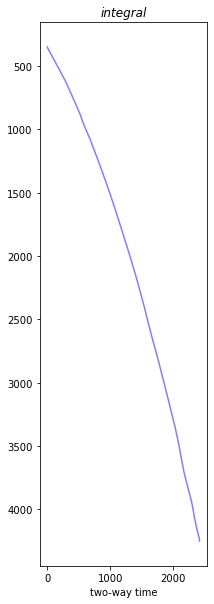

In [10]:
import matplotlib.pyplot as plt
from scipy import interpolate

f = interpolate.interp1d(tcum,z)

tdr_z = f(tcum)

f1 = plt.figure(figsize = (3,10))
plt.plot(tcum, tdr_z, 'b', alpha = 0.5)
plt.gca().invert_yaxis()
plt.title('integral', style = 'italic')
plt.xlabel('two-way time')

In [14]:
print("x length:", len(tcum),"\ny length:",len(z))

x length: 25621 
y length: 25621


In [15]:
#convert grid nodes to depth
zcon = f(twt)

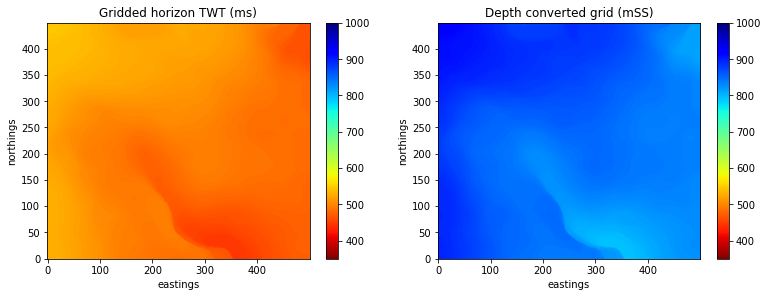

In [16]:
hxmin = hx.min()
hxmax = hx.max()
hymin = hy.min()
hymax = hy.max()

from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[hxmin:hxmax:1,hymin:hymax:1]

grid_twt = griddata((hx,hy), twt, (grid_x, grid_y), method ='nearest')
grid_zcon = griddata((hx,hy), zcon, (grid_x, grid_y), method ='nearest')

fig, axs = plt.subplots(1, 2, figsize=(11, 4))
im1 = axs[0].imshow(grid_twt.T, cmap = 'jet_r',vmin=350,vmax=1000,origin='lower',aspect=1)
axs[0].set_xlabel('eastings')
axs[0].set_ylabel('northings')
axs[0].set_title('Gridded horizon TWT (ms)')
plt.colorbar(im1,ax=axs[0])

im2 = axs[1].imshow(grid_zcon.T, cmap = 'jet_r',origin='lower',vmin=350,vmax=1000,aspect=1)
axs[1].set_xlabel('eastings')
axs[1].set_ylabel('northings')
axs[1].set_title('Depth converted grid (mSS)')
plt.colorbar(im2,ax=axs[1])
plt.tight_layout()

Export to petrel Charisma grid:

In [17]:
x = np.round(hy,decimals=2)
y = np.round(hx,decimals=2)
z = np.round(zcon,decimals=4)
depth_xyz = list(zip(x,y,z))
np.savetxt('Penobscot_depth_xyz.txt',depth_xyz,delimiter='  ')